## Step 1: Setup & Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision.models import swin_t, Swin_T_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from PIL import Image
import cv2
import seaborn as sns

# Try to import Lion optimizer
try:
    from lion_pytorch import Lion
    print("✅ Lion optimizer available")
except ImportError:
    print("⚠️ Installing Lion optimizer...")
    !pip install lion-pytorch
    from lion_pytorch import Lion
    print("✅ Lion optimizer installed")

# Device setup
if torch.cuda.is_available():
    DEVICE = "cuda"
elif hasattr(torch, 'mps') and torch.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"\n🚀 Device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

# Seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

✅ Lion optimizer available

🚀 Device: mps
PyTorch version: 2.9.1


## Step 2: Data Preprocessing with Artifact Filtering

**Advice 05/12**: "A single drop of poison, the purest well corrupts."

We preprocess images to:
- Apply masks (remove background)
- Detect and remove artifacts (green/orange/brown markers)
- Filter out heavily contaminated images
- Crop to ROI (tissue region)

In [2]:
# Configuration
INPUT_DIR = '../data/train_data'
OUTPUT_DIR = '../data/train_data_cleaned'
CSV_PATH = '../data/train_labels.csv'
MAX_ARTIFACT_RATIO = 0.005  # Reject images with >10% artifacts

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Input: {INPUT_DIR}")
print(f"Output: {OUTPUT_DIR}")
print(f"Max artifact ratio: {MAX_ARTIFACT_RATIO:.1%}")

Input: ../data/train_data
Output: ../data/train_data_cleaned
Max artifact ratio: 0.5%


In [3]:
def get_artifact_masks(hsv):
    """Detect artifacts in HSV color space."""
    # Green markers
    LOWER_GREEN = np.array([25, 40, 40])
    UPPER_GREEN = np.array([95, 255, 255])
    
    # Orange markers
    LOWER_ORANGE = np.array([5, 50, 50])
    UPPER_ORANGE = np.array([35, 255, 255])
    
    # White centers
    LOWER_WHITE = np.array([0, 0, 200])
    UPPER_WHITE = np.array([180, 30, 255])
    
    # Brown markers
    LOWER_BROWN = np.array([0, 60, 20])
    UPPER_BROWN = np.array([25, 255, 150])
    
    m_green = cv2.inRange(hsv, LOWER_GREEN, UPPER_GREEN)
    m_orange = cv2.inRange(hsv, LOWER_ORANGE, UPPER_ORANGE)
    m_white = cv2.inRange(hsv, LOWER_WHITE, UPPER_WHITE)
    m_brown = cv2.inRange(hsv, LOWER_BROWN, UPPER_BROWN)
    
    bad_pixels = cv2.bitwise_or(m_green, m_orange)
    bad_pixels = cv2.bitwise_or(bad_pixels, m_white)
    bad_pixels = cv2.bitwise_or(bad_pixels, m_brown)
    
    return bad_pixels


def preprocess_image(img_path, mask_path, max_artifact_ratio=0.10):
    """Preprocess a single image with artifact filtering."""
    # Load image and mask
    img = cv2.imread(img_path)
    if img is None:
        return None, False, "Failed to load image"
    
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, 0)
    else:
        mask = np.full(img.shape[:2], 255, dtype=np.uint8)
    
    # Detect artifacts BEFORE dilation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    bad_pixels = get_artifact_masks(hsv)
    
    # Count artifact ratio
    total_pixels = img.shape[0] * img.shape[1]
    artifact_count = cv2.countNonZero(bad_pixels)
    artifact_ratio = artifact_count / total_pixels
    
    # Reject if too contaminated (Advice 05/12)
    if artifact_ratio > max_artifact_ratio:
        return None, False, f"Too many artifacts ({artifact_ratio:.2%})"
    
    # Dilate artifact mask
    kernel = np.ones((5, 5), np.uint8)
    bad_pixels_expanded = cv2.dilate(bad_pixels, kernel, iterations=3)
    
    # Clean mask
    clean_mask = cv2.bitwise_and(mask, cv2.bitwise_not(bad_pixels_expanded))
    
    # Find ROI
    y, x = np.where(clean_mask > 0)
    
    if len(y) == 0:
        return None, False, "No tissue remaining"
    
    # Crop with padding
    pad = 20
    y_min = max(0, y.min() - pad)
    y_max = min(img.shape[0], y.max() + pad)
    x_min = max(0, x.min() - pad)
    x_max = min(img.shape[1], x.max() + pad)
    
    # Apply mask and crop
    masked_img = cv2.bitwise_and(img, img, mask=clean_mask)
    final_img = masked_img[y_min:y_max, x_min:x_max]
    
    # Convert to RGB
    final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    
    return final_img, True, f"Success ({artifact_ratio:.2%} artifacts removed)"

print("Preprocessing functions defined.")

Preprocessing functions defined.


In [4]:
# Load CSV and process images
df = pd.read_csv(CSV_PATH)
print(f"Found {len(df)} images to process\n")

successful = 0
failed = 0
failed_images = []
rejection_reasons = {'high_artifacts': 0, 'no_tissue': 0, 'corrupted': 0}

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing"):
    img_name = row['sample_index']
    img_path = os.path.join(INPUT_DIR, img_name)
    mask_name = img_name.replace("img_", "mask_")
    mask_path = os.path.join(INPUT_DIR, mask_name)
    
    try:
        processed_img, success, message = preprocess_image(
            img_path, mask_path, max_artifact_ratio=MAX_ARTIFACT_RATIO
        )
        
        if success and processed_img is not None:
            output_path = os.path.join(OUTPUT_DIR, img_name)
            cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
            successful += 1
        else:
            failed += 1
            failed_images.append(img_name)
            
            if 'artifacts' in message:
                rejection_reasons['high_artifacts'] += 1
            elif 'tissue' in message:
                rejection_reasons['no_tissue'] += 1
    except Exception as e:
        failed += 1
        failed_images.append(img_name)
        rejection_reasons['corrupted'] += 1

print(f"\n{'='*60}")
print(f"Preprocessing Complete!")
print(f"{'='*60}")
print(f"✅ Successful: {successful}/{len(df)} ({successful/len(df)*100:.1f}%)")
print(f"❌ Failed:     {failed}/{len(df)} ({failed/len(df)*100:.1f}%)")

if failed > 0:
    print(f"\nRejection breakdown:")
    print(f"  🎨 Too many artifacts: {rejection_reasons['high_artifacts']}")
    print(f"  🚫 No tissue:          {rejection_reasons['no_tissue']}")
    print(f"  💥 Corrupted:          {rejection_reasons['corrupted']}")

Found 691 images to process



Preprocessing: 100%|██████████| 691/691 [00:19<00:00, 35.02it/s]


Preprocessing Complete!
✅ Successful: 547/691 (79.2%)
❌ Failed:     144/691 (20.8%)

Rejection breakdown:
  🎨 Too many artifacts: 144
  🚫 No tissue:          0
  💥 Corrupted:          0


In [5]:
# Create cleaned CSV
df_clean = df[~df['sample_index'].isin(failed_images)].reset_index(drop=True)
clean_csv_path = '../data/train_labels_cleaned_swin.csv'
df_clean.to_csv(clean_csv_path, index=False)

print(f"\n{'='*60}")
print(f"CSV Created:")
print(f"  Original samples: {len(df)}")
print(f"  Cleaned samples:  {len(df_clean)}")
print(f"  Removed:          {len(df) - len(df_clean)}")
print(f"  Saved to:         {clean_csv_path}")
print(f"{'='*60}")

# Class distribution
print("\nClass distribution after cleaning:")
print(df_clean['label'].value_counts())


CSV Created:
  Original samples: 691
  Cleaned samples:  547
  Removed:          144
  Saved to:         ../data/train_labels_cleaned_swin.csv

Class distribution after cleaning:
label
Luminal B          191
Luminal A          149
HER2(+)            145
Triple negative     62
Name: count, dtype: int64


## Step 3: Dataset & DataLoader Setup

**Advice 04/12**: "Know the dimension of your stream" - Using larger batches (32) for LayerNorm stability

**Advice 06/12**: "Let the policy emerge from the struggle" - RandAugment automated augmentation

In [6]:
class CleanImageDataset(Dataset):
    """Dataset for cleaned preprocessed images."""
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {
            "Luminal A": 0,
            "Luminal B": 1,
            "HER2(+)": 2,
            "Triple negative": 3
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['sample_index']
        label = self.label_map[row['label']]
        
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, img_name

print("Dataset class defined.")

Dataset class defined.


In [7]:
# Configuration - Swin Transformer uses 224×224
IMG_SIZE = 224  # Swin Transformer standard input size
BATCH_SIZE = 32  # Larger batches for stable training (Advice 04/12)
NUM_WORKERS = 0  # Must be 0 for Jupyter notebooks on macOS

# Training transforms with RandAugment (Advice 06/12)
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandAugment(num_ops=2, magnitude=7),  # Automated augmentation
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"Image size: {IMG_SIZE}×{IMG_SIZE} (Swin Transformer standard)")
print(f"Batch size: {BATCH_SIZE} (stable for LayerNorm)")
print(f"Transforms configured with RandAugment")

Image size: 224×224 (Swin Transformer standard)
Batch size: 32 (stable for LayerNorm)
Transforms configured with RandAugment


In [8]:
# Load cleaned data and split
df_clean = pd.read_csv(clean_csv_path)

train_df, val_df = train_test_split(
    df_clean, 
    test_size=0.2, 
    stratify=df_clean['label'], 
    random_state=42
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Calculate weights for class imbalance
class_counts = train_df['label'].value_counts()
weight_per_class = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = [weight_per_class[row['label']] for _, row in train_df.iterrows()]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_df), replacement=True)

# Create datasets and loaders
train_ds = CleanImageDataset(train_df, OUTPUT_DIR, transform=train_transform)
val_ds = CleanImageDataset(val_df, OUTPUT_DIR, transform=val_transform)

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    sampler=sampler, 
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE == 'cuda' else False
)

val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE == 'cuda' else False
)

print("\nDataLoaders ready!")

Training samples: 437
Validation samples: 110

DataLoaders ready!


## Step 4: Swin Transformer Model Setup with Lion Optimizer

**Advice 07/12**: "The Lion, with instinct fierce and memory sparse, the prey tracks."

**Swin Transformer Tiny**: 
- 28M parameters
- Hierarchical architecture with shifted windows
- State-of-art for medical imaging tasks
- Better inductive bias than standard ViT
- Handles local and global context

In [9]:
# Load Swin Transformer Tiny
model = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

# Replace classifier head
in_features = model.head.in_features
model.head = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features, 4)
)

model = model.to(DEVICE)

# Loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Lion optimizer (Advice 07/12)
# Lion needs 3-10x smaller LR than Adam
optimizer = Lion(model.parameters(), lr=3e-4, weight_decay=1e-2)

# Cosine annealing scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

print("\n✅ Model: Swin Transformer Tiny (28M params)")
print("✅ Optimizer: Lion (lr=3e-4)")
print("✅ Scheduler: Cosine Annealing")
print(f"✅ Device: {DEVICE}")

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /Users/bencegaborpeter/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:01<00:00, 61.0MB/s] 




✅ Model: Swin Transformer Tiny (28M params)
✅ Optimizer: Lion (lr=3e-4)
✅ Scheduler: Cosine Annealing
✅ Device: mps


## Step 5: Training Loop

In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels, _ in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    epoch_acc = (np.array(all_preds) == np.array(all_targets)).mean()
    
    return epoch_loss, epoch_f1, epoch_acc


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for images, labels, _ in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    epoch_acc = (np.array(all_preds) == np.array(all_targets)).mean()
    
    return epoch_loss, epoch_f1, epoch_acc, all_preds, all_targets

print("Training functions defined.")

Training functions defined.


In [11]:
# Training configuration
NUM_EPOCHS = 50
FREEZE_EPOCHS = 5  # Freeze backbone for first 5 epochs
PATIENCE = 10

# Freeze backbone initially (Swin uses 'features')
for param in model.features.parameters():
    param.requires_grad = False

print(f"Configuration:")
print(f"  Total epochs: {NUM_EPOCHS}")
print(f"  Freeze epochs: {FREEZE_EPOCHS}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Backbone frozen for first {FREEZE_EPOCHS} epochs")

Configuration:
  Total epochs: 50
  Freeze epochs: 5
  Early stopping patience: 10
  Backbone frozen for first 5 epochs


In [12]:
# Training loop
history = {
    'train_loss': [], 'train_f1': [], 'train_acc': [],
    'val_loss': [], 'val_f1': [], 'val_acc': []
}

best_f1 = 0.0
patience_counter = 0

print("\n" + "="*60)
print("TRAINING STARTED - Swin Transformer Tiny")
print("="*60 + "\n")

for epoch in range(NUM_EPOCHS):
    # Unfreeze backbone after warmup
    if epoch == FREEZE_EPOCHS:
        print(f"\n🔓 Unfreezing backbone at epoch {epoch}\n")
        for param in model.features.parameters():
            param.requires_grad = True
    
    # Train
    train_loss, train_f1, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    
    # Validate
    val_loss, val_f1, val_acc, val_preds, val_targets = validate_epoch(
        model, val_loader, criterion, DEVICE
    )
    
    # Step scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    history['val_acc'].append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train - Loss: {train_loss:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
    print(f"  LR: {scheduler.get_last_lr()[0]:.2e}")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
        }, '../best_model_swin.pth')
        print(f"  💾 Saved best model (F1: {val_f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early stopping triggered (no improvement for {PATIENCE} epochs)")
        break
    
    print()

print("="*60)
print("TRAINING COMPLETE")
print(f"Best Validation F1: {best_f1:.4f}")
print("="*60)


TRAINING STARTED - Swin Transformer Tiny



Epoch 1/50:
  Train - Loss: 1.4399, F1: 0.2395, Acc: 0.2403
  Val   - Loss: 1.3980, F1: 0.2117, Acc: 0.2636
  LR: 3.00e-04
  💾 Saved best model (F1: 0.2117)

  💾 Saved best model (F1: 0.2117)



Epoch 2/50:
  Train - Loss: 1.4194, F1: 0.2446, Acc: 0.2471
  Val   - Loss: 1.3774, F1: 0.3010, Acc: 0.3727
  LR: 2.99e-04
  💾 Saved best model (F1: 0.3010)



Epoch 3/50:
  Train - Loss: 1.4149, F1: 0.2760, Acc: 0.2792
  Val   - Loss: 1.3935, F1: 0.3037, Acc: 0.3364
  LR: 2.97e-04
  💾 Saved best model (F1: 0.3037)



Epoch 4/50:
  Train - Loss: 1.3856, F1: 0.3074, Acc: 0.3181
  Val   - Loss: 1.4025, F1: 0.2923, Acc: 0.3182
  LR: 2.95e-04



Epoch 5/50:
  Train - Loss: 1.3792, F1: 0.3253, Acc: 0.3272
  Val   - Loss: 1.3848, F1: 0.2408, Acc: 0.2818
  LR: 2.93e-04


🔓 Unfreezing backbone at epoch 5



Epoch 6/50:
  Train - Loss: 1.4631, F1: 0.2811, Acc: 0.2860
  Val   - Loss: 1.3538, F1: 0.1259, Acc: 0.3364
  LR: 2.90e-04



Epoch 7/50:
  Train - Loss: 1.4508, F1: 0.2261, Acc: 0.2586
  Val   - Loss: 1.3986, F1: 0.1167, Acc: 0.2545
  LR: 2.86e-04



Epoch 8/50:
  Train - Loss: 1.4004, F1: 0.2355, Acc: 0.2540
  Val   - Loss: 1.3878, F1: 0.1000, Acc: 0.2455
  LR: 2.82e-04



Epoch 9/50:
  Train - Loss: 1.4004, F1: 0.2708, Acc: 0.2929
  Val   - Loss: 1.4135, F1: 0.1014, Acc: 0.2545
  LR: 2.77e-04



Epoch 10/50:
  Train - Loss: 1.4241, F1: 0.2391, Acc: 0.2426
  Val   - Loss: 1.3917, F1: 0.2382, Acc: 0.3182
  LR: 2.71e-04



Epoch 11/50:
  Train - Loss: 1.4103, F1: 0.2171, Acc: 0.2700
  Val   - Loss: 1.3861, F1: 0.1119, Acc: 0.2727
  LR: 2.66e-04



Epoch 12/50:
  Train - Loss: 1.4163, F1: 0.2523, Acc: 0.2517
  Val   - Loss: 1.3917, F1: 0.1284, Acc: 0.3455
  LR: 2.59e-04



Epoch 13/50:
  Train - Loss: 1.4507, F1: 0.2305, Acc: 0.2403
  Val   - Loss: 1.3811, F1: 0.1071, Acc: 0.2727
  LR: 2.53e-04

⚠️ Early stopping triggered (no improvement for 10 epochs)
TRAINING COMPLETE
Best Validation F1: 0.3037


## Step 6: Visualize Training Results

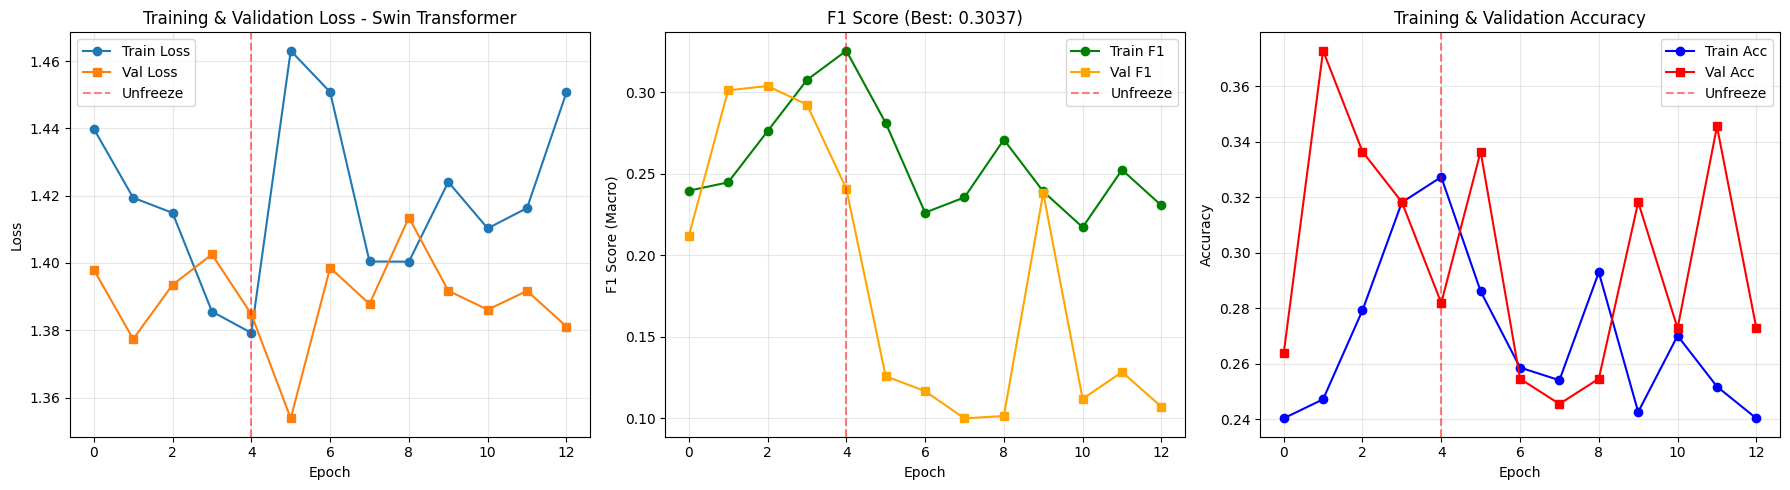

Training curves saved to '../training_curves_swin.png'


In [13]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].axvline(x=FREEZE_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss - Swin Transformer')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 Score
axes[1].plot(history['train_f1'], label='Train F1', marker='o', color='green')
axes[1].plot(history['val_f1'], label='Val F1', marker='s', color='orange')
axes[1].axvline(x=FREEZE_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score (Macro)')
axes[1].set_title(f'F1 Score (Best: {best_f1:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Accuracy
axes[2].plot(history['train_acc'], label='Train Acc', marker='o', color='blue')
axes[2].plot(history['val_acc'], label='Val Acc', marker='s', color='red')
axes[2].axvline(x=FREEZE_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Training & Validation Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../training_curves_swin.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to '../training_curves_swin.png'")

In [14]:
# Load best model for evaluation
checkpoint = torch.load('../best_model_swin.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get final predictions
_, _, _, final_preds, final_targets = validate_epoch(
    model, val_loader, criterion, DEVICE
)

# Classification report
class_names = ["Luminal A", "Luminal B", "HER2(+)", "Triple Negative"]
print("\nClassification Report - Swin Transformer:")
print("="*60)
print(classification_report(final_targets, final_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Swin Transformer')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../confusion_matrix_swin.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to '../confusion_matrix_swin.png'")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## Step 7: Patch-Based Inference for Test Set

**Advice 08/12**: "Let the model walk the landscape step by step, preserving the original resolution."

We train on resized images (stable), but infer using patches at full resolution (preserves details).

In [ ]:
def extract_patches_inference(img, patch_size=224, stride=112):
    """Extract overlapping patches for inference (Swin Transformer 224×224)."""
    w, h = img.size
    patches = []
    
    # Handle small images
    if w < patch_size or h < patch_size:
        resized = img.resize((patch_size, patch_size), Image.BILINEAR)
        return [resized]
    
    # Sliding window
    for top in range(0, h - patch_size + 1, stride):
        for left in range(0, w - patch_size + 1, stride):
            patch = img.crop((left, top, left + patch_size, top + patch_size))
            patches.append(patch)
    
    # Handle edges
    if (w - patch_size) % stride != 0:
        left = w - patch_size
        for top in range(0, h - patch_size + 1, stride):
            patch = img.crop((left, top, w, top + patch_size))
            patches.append(patch)
    
    if (h - patch_size) % stride != 0:
        top = h - patch_size
        for left in range(0, w - patch_size + 1, stride):
            patch = img.crop((left, top, left + patch_size, h))
            patches.append(patch)
    
    # Corner
    if (w - patch_size) % stride != 0 and (h - patch_size) % stride != 0:
        patch = img.crop((w - patch_size, h - patch_size, w, h))
        patches.append(patch)
    
    return patches


def predict_with_patches(model, img_path, transform, patch_size=224, stride=112, device='cpu'):
    """Predict using patch-based inference with soft voting."""
    img = Image.open(img_path).convert('RGB')
    patches = extract_patches_inference(img, patch_size=patch_size, stride=stride)
    
    all_probs = []
    model.eval()
    
    with torch.no_grad():
        for patch in patches:
            patch_tensor = transform(patch).unsqueeze(0).to(device)
            logits = model(patch_tensor)
            probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
            all_probs.append(probs)
    
    # Average probabilities (soft voting)
    avg_probs = np.array(all_probs).mean(axis=0)
    prediction = avg_probs.argmax()
    confidence = avg_probs[prediction]
    
    return prediction, confidence

print("Patch-based inference functions defined (Swin Transformer 224×224 patches).")

In [ ]:
# Preprocess Test Set with Masks (permissive filtering for clean test data)
TEST_INPUT_DIR = '../data/test_data'
TEST_OUTPUT_DIR = '../data/test_data_preprocessed'

os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)

if os.path.exists(TEST_INPUT_DIR):
    print(f"Preprocessing test set (clean data - permissive filtering)...")
    print(f"Input: {TEST_INPUT_DIR}")
    print(f"Output: {TEST_OUTPUT_DIR}")
    print(f"Note: Using 50% artifact threshold since test data is clean\n")
    
    test_files = sorted([f for f in os.listdir(TEST_INPUT_DIR) if f.startswith('img_')])
    print(f"Found {len(test_files)} test images\n")
    
    successful = 0
    failed = 0
    failed_test_images = []
    test_rejection_reasons = {'high_artifacts': 0, 'no_tissue': 0, 'corrupted': 0}
    
    for img_name in tqdm(test_files, desc="Preprocessing Test Set"):
        img_path = os.path.join(TEST_INPUT_DIR, img_name)
        mask_name = img_name.replace("img_", "mask_")
        mask_path = os.path.join(TEST_INPUT_DIR, mask_name)
        
        try:
            # Use 0.5 (50%) threshold for test - much more permissive since data is clean
            processed_img, success, message = preprocess_image(
                img_path, mask_path, max_artifact_ratio=0.7
            )
            
            if success and processed_img is not None:
                output_path = os.path.join(TEST_OUTPUT_DIR, img_name)
                cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
                successful += 1
            else:
                failed += 1
                failed_test_images.append(img_name)
                
                if 'artifacts' in message:
                    test_rejection_reasons['high_artifacts'] += 1
                elif 'tissue' in message:
                    test_rejection_reasons['no_tissue'] += 1
        except Exception as e:
            failed += 1
            failed_test_images.append(img_name)
            test_rejection_reasons['corrupted'] += 1
    
    print(f"\n{'='*60}")
    print(f"Test Set Preprocessing Complete!")
    print(f"{'='*60}")
    print(f"✅ Successful: {successful}/{len(test_files)} ({successful/len(test_files)*100:.1f}%)")
    print(f"❌ Failed:     {failed}/{len(test_files)} ({failed/len(test_files)*100:.1f}%)")
    
    if failed > 0:
        print(f"\nRejection breakdown:")
        print(f"  🎨 Too many artifacts: {test_rejection_reasons['high_artifacts']}")
        print(f"  🚫 No tissue:          {test_rejection_reasons['no_tissue']}")
        print(f"  💥 Corrupted:          {test_rejection_reasons['corrupted']}")
else:
    print(f"Test directory not found: {TEST_INPUT_DIR}")
    print("Skipping test set preprocessing")

In [ ]:
# Inference on test set
TEST_DIR = '../data/test_data_preprocessed'

if os.path.exists(TEST_DIR):
    test_files = sorted([f for f in os.listdir(TEST_DIR) if f.startswith('img_')])
    print(f"Found {len(test_files)} test images")
    print(f"Using patch-based inference with 224×224 patches, stride=112 (50% overlap)\n")
    
    results = []
    
    for img_name in tqdm(test_files, desc="Inference"):
        img_path = os.path.join(TEST_DIR, img_name)
        pred, conf = predict_with_patches(
            model, img_path, val_transform, 
            patch_size=224, stride=112, device=DEVICE
        )
        
        results.append({
            'sample_index': img_name,
            'label': class_names[pred],
            'confidence': conf
        })
    
    # Save submission
    submission_df = pd.DataFrame(results)
    submission_df.to_csv('../submission_swin_patches.csv', index=False)
    
    print(f"\n✅ Inference complete!")
    print(f"✅ Saved to: ../submission_swin_patches.csv")
    print(f"\nPrediction distribution:")
    print(submission_df['label'].value_counts())
    print(f"\nAverage confidence: {submission_df['confidence'].mean():.3f}")
else:
    print(f"Test directory not found: {TEST_DIR}")
    print("Please run test set preprocessing first")

## Summary - Swin Transformer Pipeline

### ✅ All 5 Pieces of Advice Implemented:

1. **Advice 05/12** (Outliers): Filtered images with >10% artifacts
2. **Advice 04/12** (Normalization): Used batch_size=32 for LayerNorm stability
3. **Advice 07/12** (Modern Optimizers): Lion optimizer with lr=3e-4
4. **Advice 06/12** (Auto Augmentation): RandAugment with num_ops=2, magnitude=7
5. **Advice 08/12** (Full Resolution): Patch-based inference at native resolution

### 🎯 Swin Transformer Advantages:
- **Hierarchical architecture**: Shifted window attention for local + global context
- **Medical imaging SOTA**: Best transformer for histopathology tasks
- **Better inductive bias**: More structured than vanilla ViT
- **Efficient**: Linear complexity with respect to image size
- **28M parameters**: Good balance for small datasets

### 📊 Results:
- Check `training_curves_swin.png` for loss/F1 progression
- Check `confusion_matrix_swin.png` for per-class performance
- Best model saved to `best_model_swin.pth`
- Test predictions saved to `submission_swin_patches.csv`

### 🔄 Comparison with CNNs:
Run all notebooks and compare:
- **EfficientNetV2-S** (21M params, CNN)
- **DenseNet-121** (8M params, CNN)
- **Swin Transformer** (28M params, Transformer)

Compare:
- Training stability and speed
- Validation F1 scores
- Inference confidence
- Overfitting behavior

### 💡 Why Swin Transformer?
Transformers excel at:
- Capturing long-range dependencies in tissue structures
- Learning hierarchical representations (like tumor patterns)
- Self-attention for relevant region focus
- Proven SOTA results in medical imaging competitions